In [5]:
f = open("../../Categories/QuickDraw/quickDraw.txt","r")
classes = f.readlines()
f.close()

In [6]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [4]:
!mkdir Data

mkdir: Data: File exists


In [ ]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint

In [27]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
    
    all_files = glob.glob(os.path.join(root, '*.npy'))
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    
    # Load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0:max_items_per_class, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        class_name, _ = os.path.splitext(os.path.basename(file))
        class_names.append(class_name.replace('full_numpy_bitmap_','').title())
    
    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]
    
    # Split into training and testing
    vfold_size = int(x.shape[0] * vfold_ratio)
    x_test = x[:vfold_size, :]
    y_test = y[:vfold_size]
    x_train = x[vfold_size:, :]
    y_train = y[vfold_size:]
    
    return x_train, y_train, x_test, y_test, class_names

In [28]:
x_train, y_train, x_test, y_test, class_names = load_data(r"../../Data/QuickDraw/")
num_classes = len(class_names)

In [29]:
def preprocess_data(x_train, x_test, y_train, y_test, num_classes, image_size=28):
    
    # Reshape and normalize
    x_train = x_train.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    
    # Convert to categorical
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, x_test, y_train, y_test


In [30]:
x_train, x_test, y_train, y_test = preprocess_data(
        x_train, x_test, y_train, y_test, num_classes
    )

In [31]:
def create_model(input_shape, num_classes):

    model = keras.Sequential([

        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [32]:
model = create_model(x_train.shape[1:], num_classes)
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,180 (391.33 KB)

 Trainable params: 99,956 (390.45 KB)

 Non-trainable params: 224 (896.00 B)

In [34]:
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2
        )
    ]

In [35]:
model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=20,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.4483 - loss: 2.0635 - val_accuracy: 0.2217 - val_loss: 2.9983 - learning_rate: 0.0010
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7613 - loss: 0.8108 - val_accuracy: 0.5619 - val_loss: 1.4761 - learning_rate: 0.0010
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8094 - loss: 0.6508 - val_accuracy: 0.8186 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8311 - loss: 0.5734 - val_accuracy: 0.8509 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8484 - loss: 0.5175 - val_accuracy: 0.8581 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.8617 - loss: 0.4746 - val_accuracy: 0.8727 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.8687 - l

In [36]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc*100:.2f}%')


Test accuracy: 90.29%


In [37]:
def plot_sample(x_data, y_true, class_names, title="Sample Image"):
    idx = randint(0, len(x_data))
    plt.figure(figsize=(4, 4))
    plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{title}\nClass: {class_names[int(y_true[idx])]}")
    plt.axis('off')
    plt.show()

In [38]:
def predict_drawing(image, top_k=5):
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        top_indices = (-pred).argsort()[:top_k]
        return [class_names[i] for i in top_indices]

In [39]:
str(class_names)

"['Apple', 'Cat', 'Airplane', 'Ear', 'Crab', 'Car', 'Eye', 'Banana', 'Bus', 'Star', 'Sun', 'Parrot', 'Dog', 'Mushroom', 'Cake', 'Elephant', 'Circle', 'Butterfly', 'Triangle', 'Mug']"

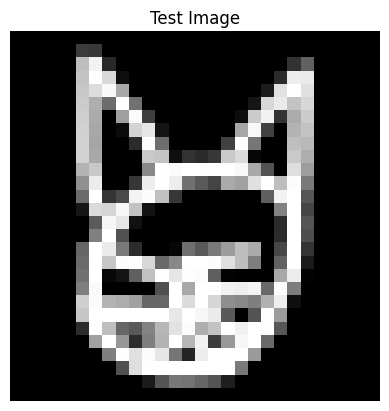

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

Top 5 predictions: ['Cat', 'Dog', 'Airplane', 'Star', 'Crab']


In [40]:
# Show sample prediction
idx = randint(0, len(x_test))
test_image = x_test[idx]

plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title("Test Image")
plt.show()

predictions = predict_drawing(test_image)
print("\nTop 5 predictions:", predictions)


In [41]:
model.save("quickDraw.keras")